# Support Vector Machine (SVM) on Breast Cancer Dataset

This notebook demonstrates the implementation of Support Vector Machine (SVM) for classification on the breast cancer dataset. We'll explore different kernels, hyperparameter tuning, and visualize the results.

## Import Required Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## Load and Explore the Dataset

In [33]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Create a DataFrame for better visualization
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Classes: {data.target_names}")
print(f"Class distribution:")
print(pd.Series(y).value_counts().sort_index())

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Dataset Info:
Shape: (569, 31)
Features: 30
Classes: ['malignant' 'benign']
Class distribution:
0    212
1    357
Name: count, dtype: int64

First 5 rows:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Exploratory Data Analysis (EDA)

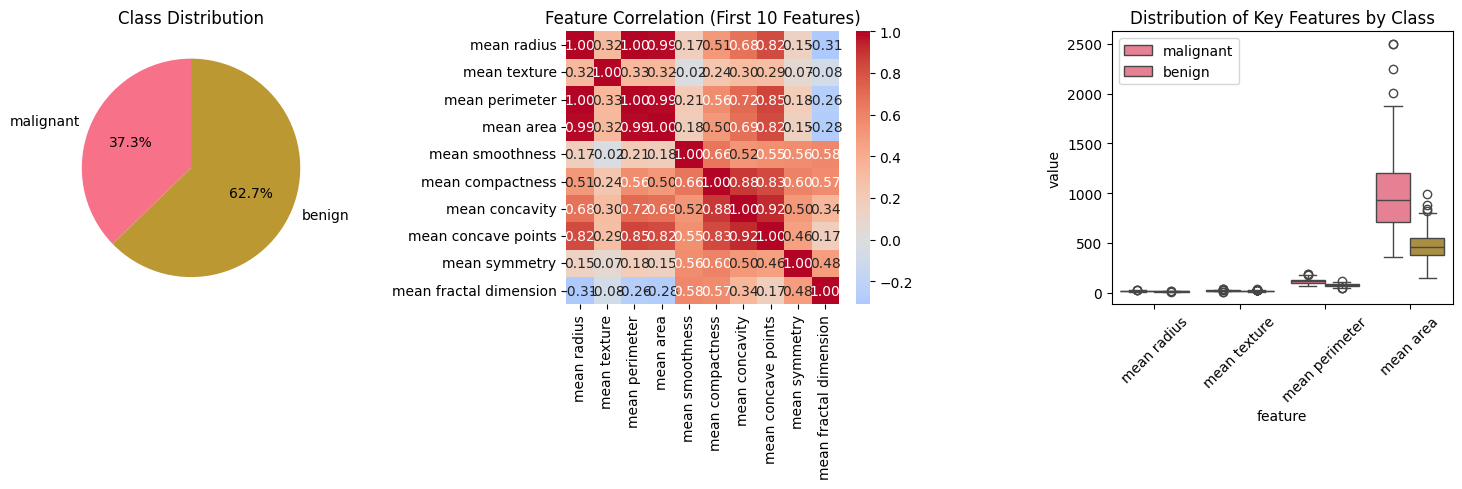

In [34]:
# Plot class distribution
plt.figure(figsize=(15, 5))

# Class distribution
plt.subplot(1, 3, 1)
counts = pd.Series(y).value_counts().sort_index()
plt.pie(counts.values, labels=data.target_names, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')

# Feature correlation heatmap (first 10 features for clarity)
plt.subplot(1, 3, 2)
correlation_matrix = df.iloc[:, :10].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation (First 10 Features)')

# Box plot for a few key features
plt.subplot(1, 3, 3)
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
df_melted = df[key_features + ['target']].melt(id_vars=['target'], var_name='feature', value_name='value')
sns.boxplot(data=df_melted, x='feature', y='value', hue='target')
plt.xticks(rotation=45)
plt.title('Distribution of Key Features by Class')
plt.legend(labels=data.target_names)

plt.tight_layout()
plt.show()

In [35]:
# Statistical summary
print("Statistical Summary of Features:")
print(df.describe())

Statistical Summary of Features:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000 

## Data Preprocessing

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Testing class distribution: {np.bincount(y_test)}")

# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed!")
print(f"Original feature range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Scaled feature range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")

Training set size: (455, 30)
Testing set size: (114, 30)
Training class distribution: [170 285]
Testing class distribution: [42 72]

Feature scaling completed!
Original feature range: [0.00, 3432.00]
Scaled feature range: [-2.72, 11.66]


## SVM Implementation with Different Kernels

In [37]:
# Test different SVM kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_results = {}

print("Training SVM models with different kernels:")
print("=" * 50)

for kernel in kernels:
    print(f"Training SVM with {kernel} kernel...")
    
    # Create and train SVM model
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = svm_model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    svm_results[kernel] = {
        'model': svm_model,
        'predictions': y_pred,
        'accuracy': accuracy
    }
    
    print(f"  {kernel.upper()} kernel accuracy: {accuracy:.4f}")

print("=" * 50)

Training SVM models with different kernels:
Training SVM with linear kernel...
  LINEAR kernel accuracy: 0.9737
Training SVM with poly kernel...
  POLY kernel accuracy: 0.9123
Training SVM with rbf kernel...
  RBF kernel accuracy: 0.9825
Training SVM with sigmoid kernel...
  SIGMOID kernel accuracy: 0.9298


Best performing kernel: RBF


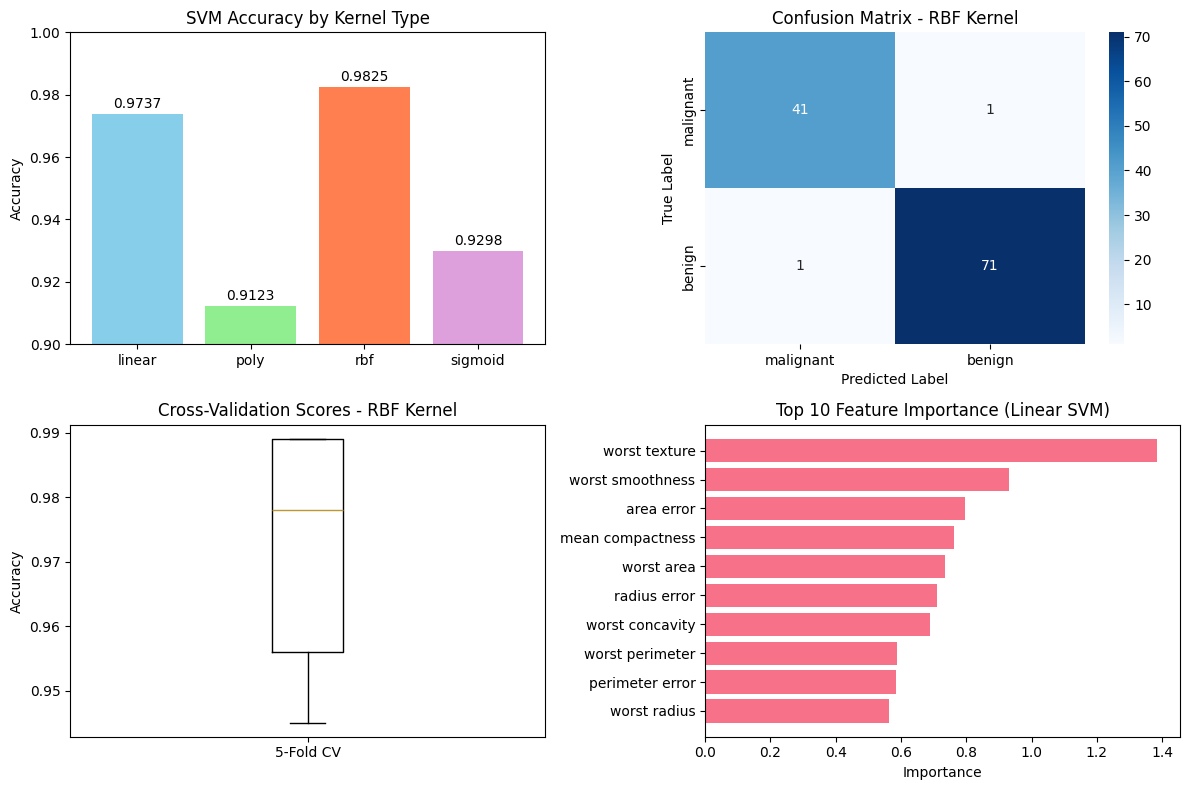

In [38]:
# Visualize kernel performance
plt.figure(figsize=(12, 8))

# Accuracy comparison
plt.subplot(2, 2, 1)
accuracies = [svm_results[kernel]['accuracy'] for kernel in kernels]
bars = plt.bar(kernels, accuracies, color=['skyblue', 'lightgreen', 'coral', 'plum'])
plt.title('SVM Accuracy by Kernel Type')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{accuracies[i]:.4f}', ha='center', va='bottom')

# Confusion matrices for best performing kernels
best_kernel = max(svm_results.keys(), key=lambda k: svm_results[k]['accuracy'])
print(f"Best performing kernel: {best_kernel.upper()}")

# Plot confusion matrix for best kernel
plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, svm_results[best_kernel]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.title(f'Confusion Matrix - {best_kernel.upper()} Kernel')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Cross-validation scores for best kernel
plt.subplot(2, 2, 3)
cv_scores = cross_val_score(svm_results[best_kernel]['model'], X_train_scaled, y_train, cv=5)
plt.boxplot(cv_scores)
plt.title(f'Cross-Validation Scores - {best_kernel.upper()} Kernel')
plt.ylabel('Accuracy')
plt.xticks([1], ['5-Fold CV'])

# Feature importance (for linear kernel only)
plt.subplot(2, 2, 4)
if 'linear' in svm_results:
    feature_importance = np.abs(svm_results['linear']['model'].coef_[0])
    top_features_idx = np.argsort(feature_importance)[-10:]
    top_features = [data.feature_names[i] for i in top_features_idx]
    top_importance = feature_importance[top_features_idx]
    
    plt.barh(range(len(top_features)), top_importance)
    plt.yticks(range(len(top_features)), top_features)
    plt.title('Top 10 Feature Importance (Linear SVM)')
    plt.xlabel('Importance')
else:
    plt.text(0.5, 0.5, 'Feature importance\nonly available for\nlinear kernel', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [39]:
# Hyperparameter tuning using GridSearchCV for RBF kernel
print("Performing hyperparameter tuning for RBF kernel...")

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

# Create SVM model
svm_rbf = SVC(kernel='rbf', random_state=42)

# Perform grid search
grid_search = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the best model
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Test accuracy with best parameters: {best_accuracy:.4f}")

Performing hyperparameter tuning for RBF kernel...
Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validation score: 0.9802
Test accuracy with best parameters: 0.9825


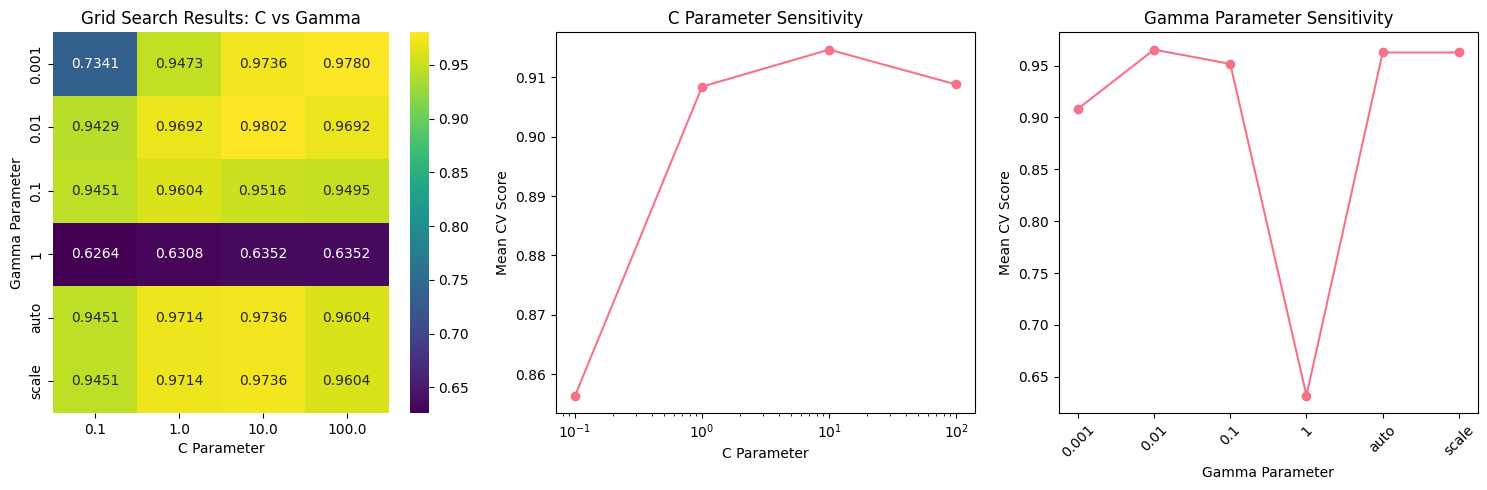

In [40]:
# Visualize hyperparameter tuning results
results_df = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(15, 5))

# Heatmap of C vs gamma performance
plt.subplot(1, 3, 1)
pivot_table = results_df.pivot_table(values='mean_test_score', 
                                    index='param_gamma', 
                                    columns='param_C')
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis')
plt.title('Grid Search Results: C vs Gamma')
plt.xlabel('C Parameter')
plt.ylabel('Gamma Parameter')

# Parameter sensitivity for C
plt.subplot(1, 3, 2)
c_scores = results_df.groupby('param_C')['mean_test_score'].mean()
plt.plot(c_scores.index, c_scores.values, marker='o')
plt.xlabel('C Parameter')
plt.ylabel('Mean CV Score')
plt.title('C Parameter Sensitivity')
plt.xscale('log')

# Parameter sensitivity for gamma
plt.subplot(1, 3, 3)
gamma_scores = results_df.groupby('param_gamma')['mean_test_score'].mean()
plt.plot(range(len(gamma_scores)), gamma_scores.values, marker='o')
plt.xlabel('Gamma Parameter')
plt.ylabel('Mean CV Score')
plt.title('Gamma Parameter Sensitivity')
plt.xticks(range(len(gamma_scores)), gamma_scores.index, rotation=45)

plt.tight_layout()
plt.show()

## Model Evaluation and Performance Metrics

Detailed Evaluation of Best SVM Model:
Best parameters: {'C': 10, 'gamma': 0.01}
Accuracy: 0.9825

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



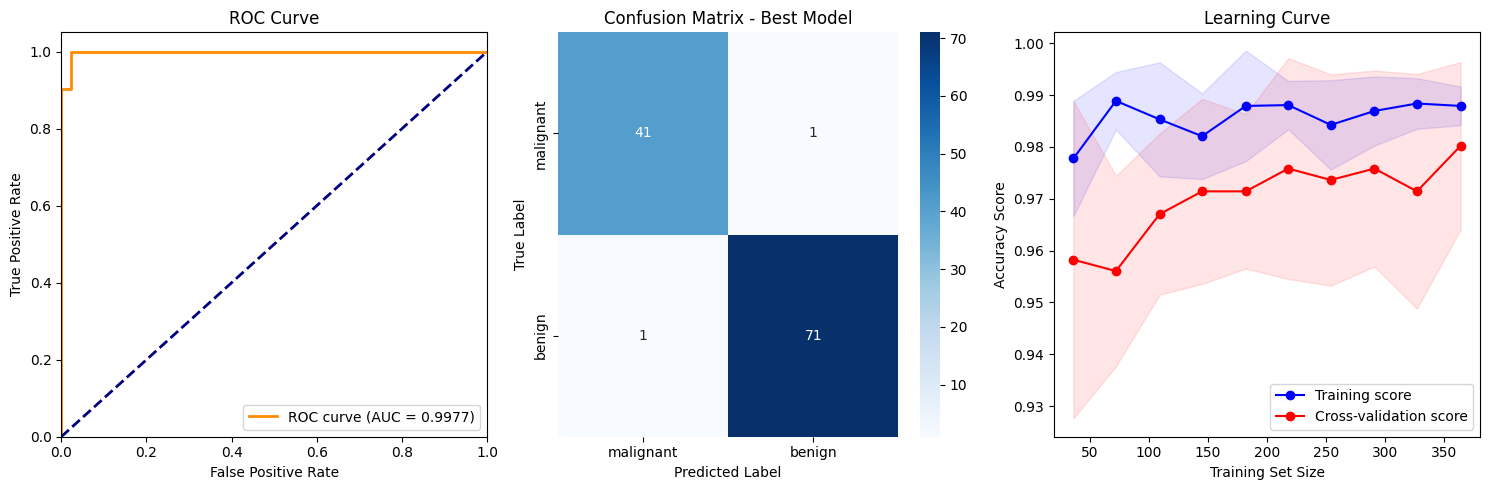

In [41]:
# Detailed evaluation of the best model
print("Detailed Evaluation of Best SVM Model:")
print("=" * 50)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Accuracy: {best_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=data.target_names))

# ROC Curve
y_pred_proba = best_svm.decision_function(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 5))

# ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Confusion Matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.title('Confusion Matrix - Best Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Learning curve
from sklearn.model_selection import learning_curve

plt.subplot(1, 3, 3)
train_sizes, train_scores, val_scores = learning_curve(
    best_svm, X_train_scaled, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Cross-validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## Decision Boundary Visualization

Creating 2D visualization using PCA...


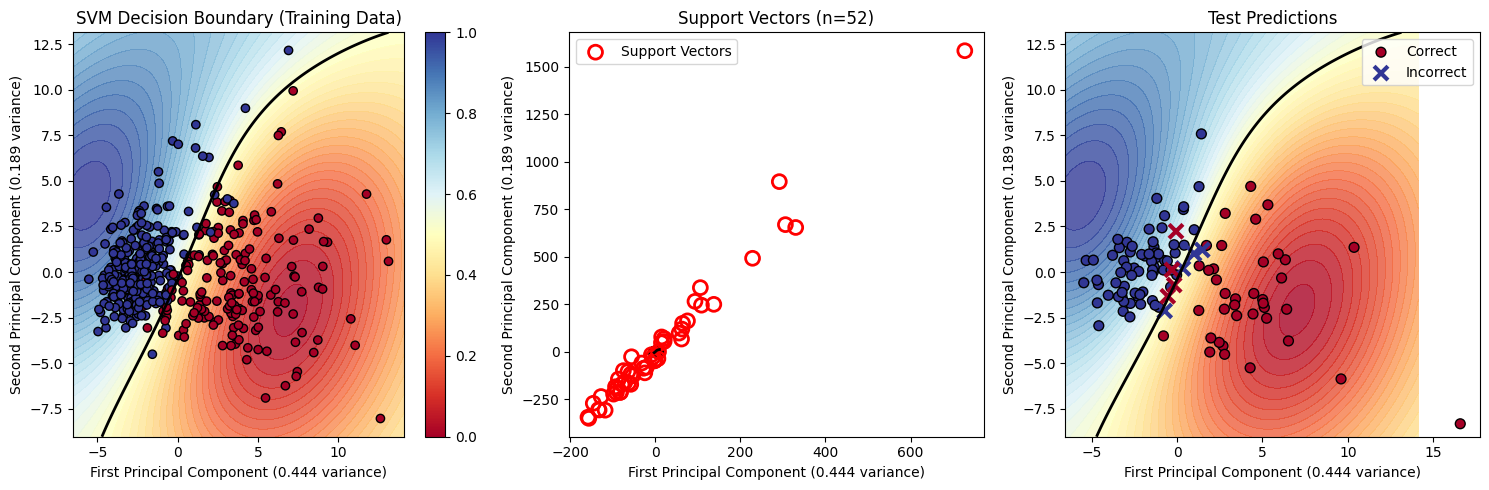

PCA explained variance: 0.634


In [42]:
# Visualize decision boundary using PCA for 2D representation
print("Creating 2D visualization using PCA...")

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train SVM on PCA-transformed data
svm_pca = SVC(kernel='rbf', C=grid_search.best_params_['C'], 
              gamma=grid_search.best_params_['gamma'], random_state=42)
svm_pca.fit(X_train_pca, y_train)

# Create a mesh for decision boundary
h = 0.02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(15, 5))

# Decision boundary
plt.subplot(1, 3, 1)
Z = svm_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap='RdYlBu')
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

# Plot training points
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='RdYlBu', edgecolors='black')
plt.colorbar(scatter)
plt.title('SVM Decision Boundary (Training Data)')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.3f} variance)')

# Support vectors
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap='RdYlBu')
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='RdYlBu', edgecolors='black')

# Highlight support vectors
support_vectors_pca = pca.transform(scaler.transform(best_svm.support_vectors_))
plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], 
           s=100, facecolors='none', edgecolors='red', linewidths=2, label='Support Vectors')
plt.title(f'Support Vectors (n={len(best_svm.support_vectors_)})')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.3f} variance)')
plt.legend()

# Test predictions
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap='RdYlBu')
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

# Plot test points with predictions
y_pred_pca = svm_pca.predict(X_test_pca)
correct_pred = (y_pred_pca == y_test)
plt.scatter(X_test_pca[correct_pred, 0], X_test_pca[correct_pred, 1], 
           c=y_test[correct_pred], cmap='RdYlBu', edgecolors='black', 
           marker='o', s=50, label='Correct')
plt.scatter(X_test_pca[~correct_pred, 0], X_test_pca[~correct_pred, 1], 
           c=y_test[~correct_pred], cmap='RdYlBu', edgecolors='red', 
           marker='x', s=100, linewidths=3, label='Incorrect')
plt.title('Test Predictions')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.3f} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.3f} variance)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")